In [22]:
# Data libs
import pandas as pd
import numpy as np

# ML libs
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve, auc, log_loss, confusion_matrix, ConfusionMatrixDisplay, f1_score, average_precision_score



from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Utils
import pickle
import warnings
import datetime

# Graph libs
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go


# Settings
pd.set_option('display.max_columns',500)
pd.set_option('display.max_rows',500)
warnings.filterwarnings('ignore')

# Global vars
random_state = 33

In [2]:
# Read data
df0 = pd.read_csv('dataset.csv', sep =';')

# Select rows where default != NaN
df = df0[df0['default'].isna() == False ]

In [3]:
X = df.drop(['uuid','default'],axis=1)
y = df['default']

In [4]:
# Split data into Train, Test, and Validation datasets.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=random_state,stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=random_state,stratify=y_train) # 0.25*0.8 = 0.2

In [27]:
num_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='median')),
    ('scale', MinMaxScaler())
])


cat_cat_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('ordinal',OneHotEncoder(handle_unknown='ignore',sparse_output=False))
])


cat_num_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='constant',fill_value=999))
])

In [28]:
feature_pipeline = ColumnTransformer(transformers=[
    ('num_pipeline',num_pipeline,
     
     [
       'account_amount_added_12_24m',
       'account_days_in_dc_12_24m', 'account_days_in_rem_12_24m',
       'account_days_in_term_12_24m', 'account_incoming_debt_vs_paid_0_24m',
       'age', 'avg_payment_span_0_12m', 'avg_payment_span_0_3m',
       'max_paid_inv_0_12m', 'max_paid_inv_0_24m',
       'num_active_div_by_paid_inv_0_12m', 'num_active_inv',
       'num_arch_dc_0_12m', 'num_arch_dc_12_24m', 'num_arch_ok_0_12m',
       'num_arch_ok_12_24m', 'num_arch_rem_0_12m',
       'num_arch_written_off_0_12m', 'num_arch_written_off_12_24m',
       'num_unpaid_bills','recovery_debt',
       'sum_capital_paid_account_0_12m', 'sum_capital_paid_account_12_24m',
       'sum_paid_inv_0_12m', 'time_hours'
        ]),
    
    
    ('cat_cat_pipeline',cat_cat_pipeline,
     
     [
        'merchant_category', 'merchant_group',
        'name_in_email', 'has_paid',
        ]),
    
    
    ('cat_num_pipeline',cat_num_pipeline,
     
     [
       'account_status', 'account_worst_status_0_3m',
       'account_worst_status_12_24m', 'account_worst_status_3_6m',
       'account_worst_status_6_12m',  
         'status_last_archived_0_24m',
       'status_2nd_last_archived_0_24m', 'status_3rd_last_archived_0_24m',
       'status_max_archived_0_6_months', 'status_max_archived_0_12_months',
       'status_max_archived_0_24_months', 'worst_status_active_inv'
        ])
    
    ],
    remainder='drop',
    n_jobs=-1)

In [29]:
lg = LogisticRegression(random_state=random_state,class_weight='balanced')

parameters = [
    {'solver' : ['saga'],
      'penalty' : ['elasticnet', 'l1', 'l2'],
      'C' : Real(1e-6, 1e+2, prior='log-uniform'),
      'l1_ratio':Real(0, 1, prior='uniform')
    },
    {'solver' : ['newton-cg', 'lbfgs'],
      'penalty' : ['l2'],
      'C' : Real(1e-6, 1e+2, prior='log-uniform'),
    }
]

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

lg_cv = BayesSearchCV(lg, parameters, cv=cv, scoring='neg_log_loss', n_jobs=-1, verbose=3)

In [30]:
lg_pipeline = Pipeline(steps=[
    ('feature_pipeline', feature_pipeline),
    ('model', lg_cv)
    
])

In [31]:
lg_pipeline.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Kla

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/l

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/s

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Kla

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Kla

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Kla

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Kla

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Kla

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Kla

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Kla

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Kla

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Kla

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Kla

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Kla

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Kla

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Kla

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Kla

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Kla

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Kla

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Kla

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Kla

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Kla

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Kla

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Kla

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/utils/optimize.py:211: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/utils/optimize.py:211: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/utils/optimize.py:211: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/utils/optimize.py:211: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/utils/optimize.

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did no

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did no

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/utils/optimize.py:211: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/utils/optimize.py:211: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.no

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did no

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did no

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did no

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did no

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did no

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/utils/optimize.py:211: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/utils/optimize.py:211: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/utils/optimize.py:211: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/utils/optimize.py:211: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/utils/optimize.

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did no

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did no

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/utils/optimize.py:211: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/utils/optimize.py:211: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.no

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did no

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/utils/optimize.py:211: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/utils/optimize.py:211: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.no

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did no

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/utils/optimize.py:211: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/utils/optimize.py:211: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.no

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/utils/optimize.py:211: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/utils/optimize.py:211: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.no

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/utils/optimize.py:211: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/utils/optimize.py:211: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/utils/optimize.py:211: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/utils/optimize.py:211: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/utils/optimize.

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did no

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/utils/optimize.py:211: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/utils/optimize.py:211: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.no

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/utils/optimize.py:211: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/utils/optimize.py:211: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/utils/optimize.py:211: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/utils/optimize.py:211: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/utils/optimize.

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/utils/optimize.py:211: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/utils/optimize.py:211: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.no

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did no

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/utils/optimize.py:211: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Use

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/utils/optimize.py:211: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/utils/optimize.py:211: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.no

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/utils/optimize.py:211: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/sklearn/utils/optimize.py:211: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/Users/parvizalizada/Documents/GitHub.no

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did no

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/parvizalizada/Documents/GitHub.nosync/Klarna case/klr/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did no

Pipeline(steps=[('feature_pipeline',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('num_pipeline',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scale',
                                                                   MinMaxScaler())]),
                                                  ['account_amount_added_12_24m',
                                                   'account_days_in_dc_12_24m',
                                                   'account_days_in_rem_12_24m',
                                                   'account_days_in_term_12_24m',
                                                   'account_incoming_debt_vs_paid_0_24m',
                                                   'age',
                                                   'avg_pa...
                               n_jobs=-1, scoring='neg_log_loss',
                               search_spaces=[{'C': Real(low=1e-06, high=100.0, prior='log-uniform', transform='normalize'),
                                               'l1_ratio': Real(low=0, high=1, prior='uniform', transform='normalize'),
                                               'penalty': ['elasticnet', 'l1',
                                                           'l2'],
                                               'solver': ['saga']},
                                              {'C': Real(low=1e-06, high=100.0, prior='log-uniform', transform='normalize'),
                                               'penalty': ['l2'],
                                               'solver': ['newton-cg',
                                                          'lbfgs']}],
                               verbose=3))])

[CV 5/5] END C=0.000157216648268923, l1_ratio=0.031112134583001334, penalty=l2, solver=saga;, score=-1.167 total time=   4.1s
[CV 4/5] END C=0.010884022395173353, l1_ratio=0.5628602866504493, penalty=elasticnet, solver=saga;, score=-0.674 total time=   5.0s
[CV 5/5] END C=0.00534829433244113, l1_ratio=0.4770662488005405, penalty=l2, solver=saga;, score=-3.934 total time=   3.9s
[CV 1/5] END C=0.00030334248083875175, l1_ratio=0.967595009327712, penalty=l2, solver=saga;, score=-1.248 total time=   4.0s
[CV 4/5] END C=0.0001397032301613737, l1_ratio=0.0936664126761883, penalty=l2, solver=saga;, score=-2.614 total time=   4.0s
[CV 2/5] END C=29.995394909157383, l1_ratio=0.03350956435806217, penalty=l2, solver=saga;, score=-0.836 total time=   4.0s
[CV 5/5] END C=8.104807987917363, l1_ratio=0.1852164423679063, penalty=l2, solver=saga;, score=-0.359 total time=   4.0s
[CV 4/5] END C=0.0001013622747322455, l1_ratio=0.027744140128616427, penalty=l2, solver=saga;, score=-2.223 total time=   4.0

[CV 4/5] END C=0.000157216648268923, l1_ratio=0.031112134583001334, penalty=l2, solver=saga;, score=-0.303 total time=   3.9s
[CV 2/5] END C=0.033798293944658546, l1_ratio=0.6660092185205861, penalty=l1, solver=saga;, score=-1.254 total time=   5.1s
[CV 4/5] END C=1.1942306149170254, l1_ratio=0.5262314503703501, penalty=l2, solver=saga;, score=-1.671 total time=   3.9s
[CV 5/5] END C=2.152452064249206e-05, l1_ratio=0.9522868587604243, penalty=l1, solver=saga;, score=-5.289 total time=   4.5s
[CV 2/5] END C=0.13517539668499592, l1_ratio=0.7945627717582758, penalty=l1, solver=saga;, score=-1.553 total time=   5.4s
[CV 2/5] END C=3.168415741553067e-05, l1_ratio=0.6014088370818449, penalty=l1, solver=saga;, score=-0.981 total time=   4.4s
[CV 4/5] END C=0.0010944462842573863, l1_ratio=0.07850312334621491, penalty=l1, solver=saga;, score=-0.377 total time=   4.8s
[CV 5/5] END C=0.010884022395173353, l1_ratio=0.5628602866504493, penalty=elasticnet, solver=saga;, score=-1.170 total time=   5.

[CV 2/5] END C=0.000157216648268923, l1_ratio=0.031112134583001334, penalty=l2, solver=saga;, score=-0.565 total time=   4.1s
[CV 5/5] END C=0.033798293944658546, l1_ratio=0.6660092185205861, penalty=l1, solver=saga;, score=-1.985 total time=   5.2s
[CV 4/5] END C=0.13517539668499592, l1_ratio=0.7945627717582758, penalty=l1, solver=saga;, score=-0.189 total time=   5.4s
[CV 3/5] END C=0.010884022395173353, l1_ratio=0.5628602866504493, penalty=elasticnet, solver=saga;, score=-0.943 total time=   5.0s
[CV 1/5] END C=9.874513896646211e-05, l1_ratio=0.5486382640667588, penalty=l2, solver=saga;, score=-0.304 total time=   4.0s
[CV 3/5] END C=0.0001397032301613737, l1_ratio=0.0936664126761883, penalty=l2, solver=saga;, score=-0.702 total time=   4.0s
[CV 4/5] END C=0.0001820188584119676, l1_ratio=0.01407277409207082, penalty=l2, solver=saga;, score=-0.759 total time=   4.0s
[CV 5/5] END C=29.995394909157383, l1_ratio=0.03350956435806217, penalty=l2, solver=saga;, score=-0.300 total time=   4

[CV 1/5] END C=0.033798293944658546, l1_ratio=0.6660092185205861, penalty=l1, solver=saga;, score=-1.336 total time=   5.1s
[CV 2/5] END C=1.1942306149170254, l1_ratio=0.5262314503703501, penalty=l2, solver=saga;, score=-0.549 total time=   3.9s
[CV 3/5] END C=2.152452064249206e-05, l1_ratio=0.9522868587604243, penalty=l1, solver=saga;, score=-1.895 total time=   4.5s
[CV 5/5] END C=3.168415741553067e-05, l1_ratio=0.6014088370818449, penalty=l1, solver=saga;, score=-2.975 total time=   4.5s
[CV 2/5] END C=0.0010944462842573863, l1_ratio=0.07850312334621491, penalty=l1, solver=saga;, score=-1.120 total time=   4.8s
[CV 3/5] END C=9.874513896646211e-05, l1_ratio=0.5486382640667588, penalty=l2, solver=saga;, score=-0.739 total time=   4.0s
[CV 2/5] END C=0.00030334248083875175, l1_ratio=0.967595009327712, penalty=l2, solver=saga;, score=-0.619 total time=   4.0s
[CV 3/5] END C=29.995394909157383, l1_ratio=0.03350956435806217, penalty=l2, solver=saga;, score=-0.798 total time=   4.0s
[CV 4

In [37]:
pickle_path = f"lg_pipeline.pkl"

with open(pickle_path, "wb") as f:
    pickle.dump(lg_pipeline, f)

In [ ]:
calibrated_xgb_clf = CalibratedClassifierCV(lg_pipeline.steps[1][1].best_estimator_, 
                                            method = 'sigmoid', cv="prefit")

calibrated_xgb_clf.fit(feature_pipeline.transform(X_val), y_val)

## Model evaluation

In [32]:
y_test_lg_pipe_pred = lg_pipeline.predict_proba(X_test)
y_train_lg_pipe_pred = lg_pipeline.predict_proba(X_train)
y_val_lg_pipe_pred = lg_pipeline.predict_proba(X_val)

In [33]:
for i in xgb_metrics:
    fpr, tpr, thresholds = roc_curve(i[0], i[1])
    auc_score = auc(fpr, tpr)
    print(auc_score)

0.9032241995429642
0.9005316467580647
0.8829989660003793


In [34]:
fig = make_subplots(rows=1, cols=3, subplot_titles=("Train", "Validation", "Test"), vertical_spacing = 0.05)

xgb_metrics = [(y_train, y_train_lg_pipe_pred[:, 1]),
                   (y_val, y_val_lg_pipe_pred[:, 1]),
                   (y_test, y_test_lg_pipe_pred[:, 1])]
count = 0
for i in xgb_metrics:
    fpr, tpr, thresholds = roc_curve(i[0], i[1])
    auc_score = auc(fpr, tpr)
    count+=1
    fig.add_trace(go.Scatter(x=fpr, y=tpr, fill='tozeroy',showlegend=False),row=1,col=count)
    fig.add_annotation(text=f'AUC={auc_score:.4f}',
                  xref="x"+str(count), yref="y"+str(count),
                  x=0.7, y=0.5, showarrow=False)
fig.update_layout(height=400, width=800, title_text="XGBoost Model")
fig.show()

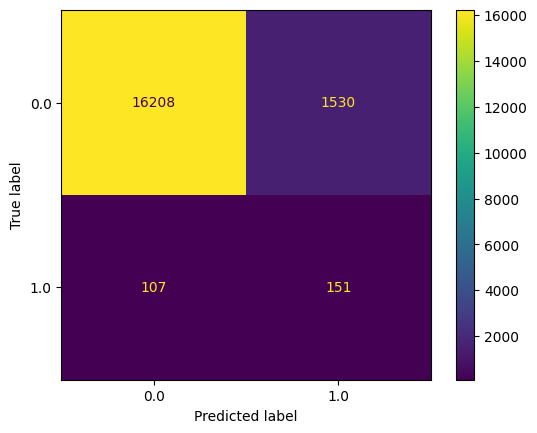

In [35]:
cm = confusion_matrix(y_test, np.where(y_test_lg_pipe_pred[:, 1]>0.7,1,0), labels=lg_pipeline.steps[1][1].best_estimator_.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=lg_pipeline.steps[1][1].best_estimator_.classes_)

disp.plot()

In [36]:
print(f'Logistic reg F1 score, validation: {f1_score(y_val, np.where(y_val_lg_pipe_pred [:,1]>0.7,1,0)):.4f}')
print(f'Logistic reg F1 score, train: {f1_score(y_train, np.where(y_train_lg_pipe_pred [:,1]>0.7,1,0)):.4f}')
print(f'Logistic reg F1 score, test: {f1_score(y_test, np.where(y_test_lg_pipe_pred [:,1]>0.7,1,0)):.4f} \n')

print(f'Logistic reg Average precision score, validation:  {average_precision_score(y_val, np.where(y_val_lg_pipe_pred [:,1]>0.7,1,0)):.4f}')
print(f'Logistic reg Average precision score, train:  {average_precision_score(y_train, np.where(y_train_lg_pipe_pred [:,1]>0.7,1,0)):.4f}')
print(f'Logistic reg Average precision score, test:  {average_precision_score(y_test, np.where(y_test_lg_pipe_pred [:,1]>0.7,1,0)):.4f}')

Logistic reg F1 score, validation: 0.1674
Logistic reg F1 score, train: 0.1740
Logistic reg F1 score, test: 0.1558 

Logistic reg Average precision score, validation:  0.0638
Logistic reg Average precision score, train:  0.0704
Logistic reg Average precision score, test:  0.0585


# Predictions

In [39]:
pred_df = df0[df0['default'].isna() == True]

pred_df_X = pred_df.drop(['uuid','default'],axis=1)

uuids = pred_df['uuid']
y_predictions = lg_pipeline.predict_proba(pred_df_X)[:,1]

In [65]:
predictions = pd.DataFrame(np.concatenate([uuids.values.reshape(-1,1),y_predictions.reshape(-1,1)],axis=1), columns=['uuid','pd'])

In [70]:
predictions.set_index('uuid').to_csv(r'predictions.csv')